# Integrate Neptune Model Context Protocol (MCP) as tools with Strands Agent

## Overview
The [Model Context Protocol (MCP)](https://modelcontextprotocol.io/introduction) is an open protocol that standardizes how applications provide context to Large Language Models (LLMs). Strands AI SDK integrates with MCP to extend agent capabilities through external tools and services.

MCP enables communication between agents and MCP servers that provide additional tools. The Strands Agent SDK includes built-in support for connecting to MCP servers and using their tools.

More info: [Strands SDK](https://strandsagents.com/latest/)

In this example we will show you the following:
- How to use Amazon Neptune MCP tools on your Strands Agent. 
- How to load Sample customer purchase data into Neptune DB using Utility.
- Connecting with Neptune DB, analysing and providing the summary based on user question. 

We will use the [AWS Labs Amazon Neptune MCP Server](https://github.com/awslabs/mcp/blob/main/src/amazon-neptune-mcp-server/README.md) which provides tools to access Amazon Neptune, analyse the schema, and run opencypher/gremlin queries. This MCP server has 3 main features:

- **Run Queries**: Execute openCypher and/or Gremlin queries against the configured database
- **Schema**: Get the schema in the configured graph as a text string
- **Status**: Find if the graph is "Available" or "Unavailable" to your server. This is useful in helping to ensure that the graph is connected.



## Agent Details
<div style="float: left; margin-right: 20px;">
    
|Feature             |Description                                        |
|--------------------|---------------------------------------------------|
|Feature used        |MCP Tools for Neptune DB                           |
|Agent Structure     |Single agent architecture                          |

</div>


## Architecture

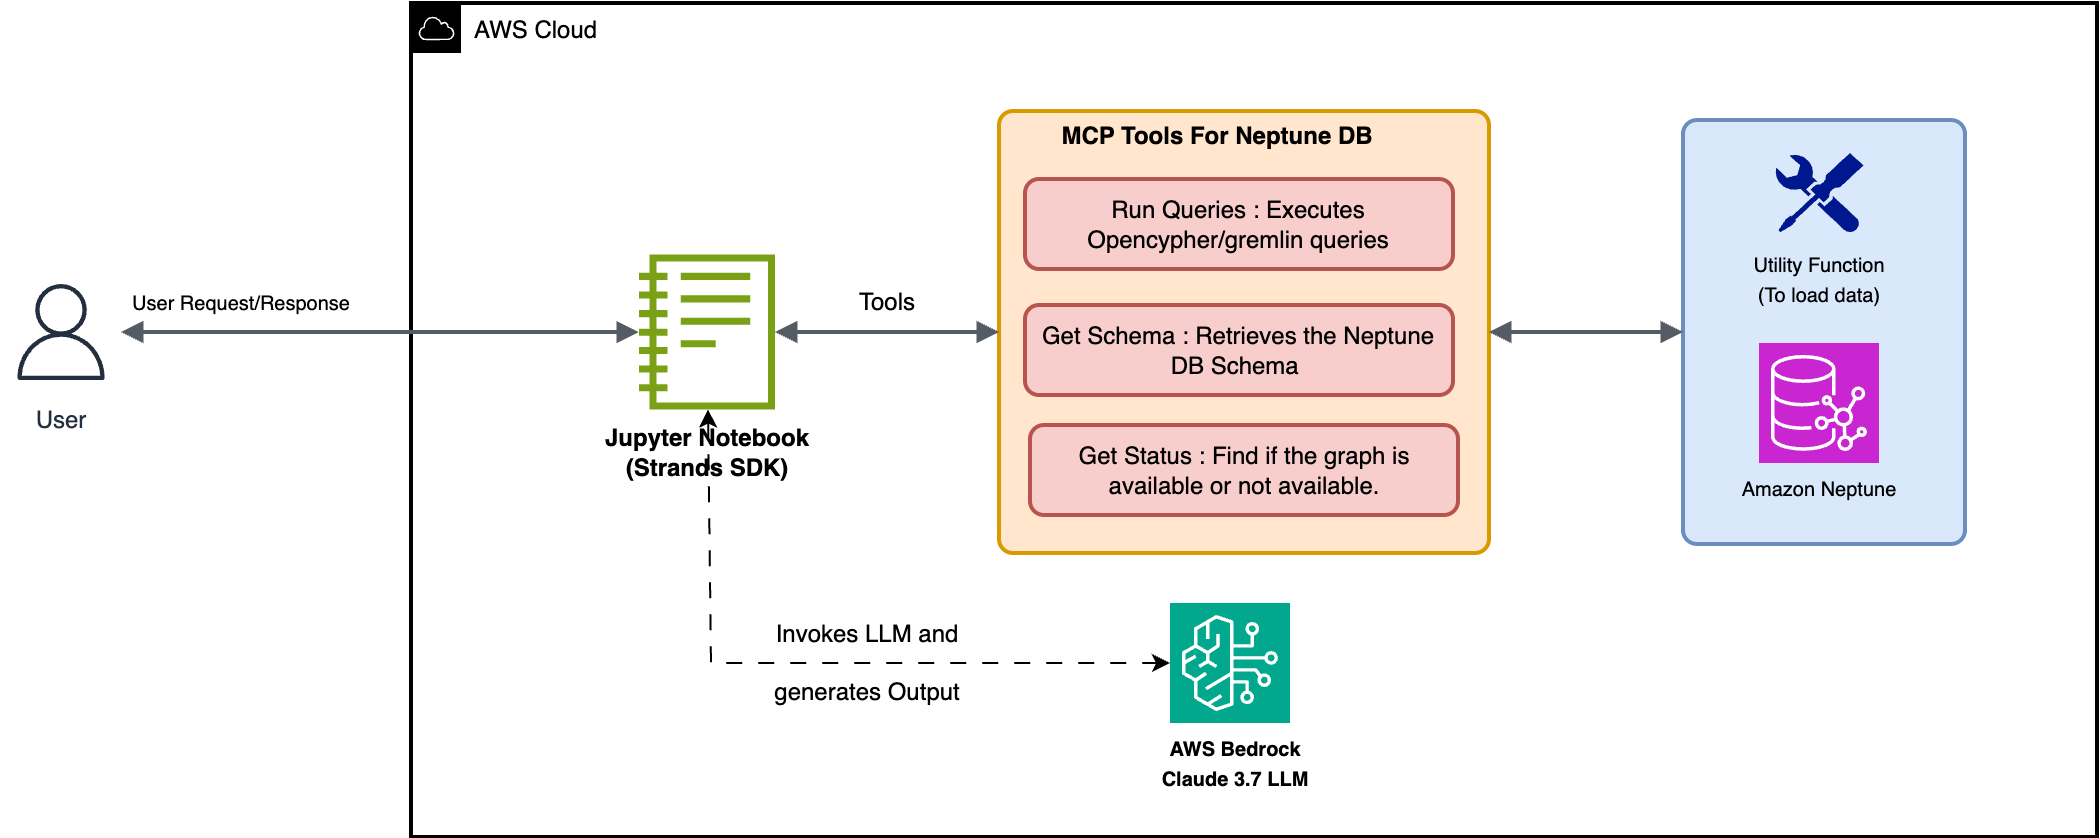


The implementation leverages the Strands Agents SDK in conjunction with the Model Composer Platform (MCP) tools to establish a seamless interaction framework between users, Amazon Bedrock LLM, and Neptune DB.

Within this architecture, the Strands Agents SDK serves as the primary intermediary, facilitating connections to the Neptune database through MCP tools. The system utilizes Amazon Bedrock LLM to formulate appropriate queries and execute them against the Neptune DB instance. Following successful data retrieval, the solution employs Bedrock LLM's processing capabilities to synthesize the information and deliver a comprehensive, user-friendly summary to the end user.

This integrated approach enhances data accessibility while maintaining robust processing workflows across all system components.

## Setup and prerequisites

### Prerequisites
* Python 3.10+
* AWS account
* Anthropic Claude 3.7 enabled on Amazon Bedrock
* Neptune DB Cluster configured and available

Let's now install the requirement packages for our Strands Agent Agent

In [11]:
# Install requirement libraries
!pip install -r requirements.txt -q

### Loading Sample Customer Purchase data into Neptune DB

We have used a sample customer purchase retail dataset from kaggle. This dataset is in CSV format and we have used a python utility neptune_loader/gremlin_csv_generator.py to convert these CSV files into [Gremlin standard](https://docs.aws.amazon.com/neptune/latest/userguide/bulk-load-tutorial-format-gremlin.html) CSV files. 

This utility requires comprehensive schema information regarding the Nodes and their connecting edges based on the Source file to be processed. This essential information must be provided through the completion of the configuration JSON file. Once executed it provides the list of gremlin standard csv files which is ready to be loaded in Neptune DB.

Format with Example:
```
  "nodes": [
      {
        "label": "Customer Purchase",  -- Node Label
        "file_name": "customer_purchase",  -- Gremlin CSV filename for Node
        "node_cols": [
          "CustomerID:string"              -- Source Column To be used for creating Nodes
        ],
        "properties": {     -- Additional Properties to be part of the Node (can be from source data or text field
          "Country of Residence": "Country:string",
          "context_type": "Customer details",
          "description": "Customer Purchase history Tree",
          "tree_name": "Customer Purchase history",
          "effectiveFrom": "20250401120000"
        }
      }
      
      
      "edges": [
      {
        "label": "Purchased",         -- Edge label
        "file_name": "customer_products", -- Filename for edge files
        "from_cols": [
          "CustomerID:string"            -- Edge connecting From nodelColumn name (must match with node cols above)
        ],
        "to_cols": [                     -- Edge connection to node column name 
          "InvoiceNo:string",
          "StockCode:string"
        ],
        "from_label": "customer_purchase", --- Edge connecting from Node Label
        "to_label": "product_purchased",   --- Edge connecting to Node label
        "properties": {}
      }

```

In [1]:
import pandas as pd
import numpy as np
from neptune_loader.gremlin_csv_generator import generate_gremlin_files


In [2]:
# Source data to the loaded
src_data_location = 'data/customer_data.csv' 
src_format_location = 'neptune_loader/customer_data.json'

In [3]:
# Create gremlin standard files using neptune utility
# Note: It always needs the json file to be created to map the relationship between nodes

generate_gremlin_files(src_data_location,src_format_location)

ic| file_name: 'customer_data'
ic| node: {'file_name': 'customer_purchase',
           'label': 'Customer Purchase',
           'node_cols': ['CustomerID:string'],
           'properties': {'Country_of_Residence': 'Country:string',
                          'context_type': 'Customer details',
                          'description': 'Customer Purchase history Tree',
                          'effectiveFrom': '20250401120000',
                          'tree_name': 'Customer Purchase history'}}
ic| cols: ['CustomerID:string']
ic| filter_query: None
ic| nodes_df.columns: Index(['CustomerID:string', '~label', 'Country_of_Residence:string',
                             'context_type:string', 'description:string', 'tree_name:string',
                             'effectiveFrom:string', '~id'],
                            dtype='object')
ic| node: {'file_name': 'product_purchased',
           'label': 'Product Purchased',
           'node_cols': ['InvoiceNo:string', 'StockCode:string'],
    

In [8]:
# Provide the bucket name you want the data to be copied. 
# Ensure the Notebook Instance has necessary S3 permissions to read and write files.
bucket_name = "neptune-strands-store-poc" 

# Copy the created gremlin files to S3 bucket
prefix_name = "customer-data"

!aws s3 cp nodes/ s3://{bucket_name}/gremlin/{prefix_name}/nodes/ --recursive
!aws s3 cp edges/ s3://{bucket_name}/gremlin/{prefix_name}/edges/ --recursive

upload: nodes/customer_data_customer_purchase.csv to s3://neptune-strands-store-poc/gremlin/customer-data/nodes/customer_data_customer_purchase.csv
upload: nodes/customer_data_product_purchased.csv to s3://neptune-strands-store-poc/gremlin/customer-data/nodes/customer_data_product_purchased.csv
upload: edges/customer_data_customer_products.csv to s3://neptune-strands-store-poc/gremlin/customer-data/edges/customer_data_customer_products.csv


In [16]:

# Loading Nodes into Neptune DB using Curl command
# Provide the Host name of Neptune DB
HOST='db-neptune-1.cluster-chow2sm86ya0.us-west-2.neptune.amazonaws.com' 

!awscurl --service neptune-db --region us-west-2 -X POST \
    -H 'Content-Type: application/json' \
    $HOST:8182/loader -d \
    '{"source" : "s3://neptune-strands-store-poc/gremlin/customer-data/nodes/","format" : "csv","iamRoleArn" : "arn:aws:iam::029696018720:role/NeptuneLoadFromS3","region" : "us-west-2","failOnError" : "TRUE","parallelism" : "MEDIUM","updateSingleCardinalityProperties" : "FALSE","queueRequest" : "TRUE"}'

{
    "status" : "200 OK",
    "payload" : {
        "loadId" : "d058821c-e59a-479e-9d99-8ab68ee5abcc"
    }
}


In [17]:
# Loading Edges into Neptune DB

!awscurl --service neptune-db --region us-west-2 -X POST \
    -H 'Content-Type: application/json' \
    $HOST:8182/loader -d \
    '{"source" : "s3://neptune-strands-store-poc/gremlin/customer-data/edges/","format" : "csv","iamRoleArn" : "arn:aws:iam::029696018720:role/NeptuneLoadFromS3","region" : "us-west-2","failOnError" : "TRUE","parallelism" : "MEDIUM","updateSingleCardinalityProperties" : "FALSE","queueRequest" : "TRUE"}'

{
    "status" : "200 OK",
    "payload" : {
        "loadId" : "37aab05b-2af0-48eb-950e-4e9c89072d64"
    }
}


In [24]:
# You can monitor the load using the below command using the loadID in the payload
!awscurl --service neptune-db --region us-west-2 -X GET "https://"$HOST":8182/loader/d058821c-e59a-479e-9d99-8ab68ee5abcc?details=true&errors=true&page=1&errorsPerPage=3"
 


{
    "status" : "200 OK",
    "payload" : {
        "feedCount" : [
            {
                "LOAD_COMPLETED" : 2
            }
        ],
        "overallStatus" : {
            "fullUri" : "s3://neptune-strands-store-poc/gremlin/customer-data/nodes/",
            "runNumber" : 1,
            "retryNumber" : 0,
            "status" : "LOAD_COMPLETED",
            "totalTimeSpent" : 178,
            "startTime" : 1748562737,
            "totalRecords" : 4280411,
            "totalDuplicates" : 0,
            "parsingErrors" : 0,
            "datatypeMismatchErrors" : 0,
            "insertErrors" : 0
        },
        "errors" : {
            "startIndex" : 0,
            "endIndex" : 0,
            "loadId" : "d058821c-e59a-479e-9d99-8ab68ee5abcc",
            "errorLogs" : [ ]
        }
    }
}


#### Data loading into Neptune is now completed. 

Additionally, you can view the created data using Neptune Graph explorer

We have loaded 530k of Records into Neptune Graph database

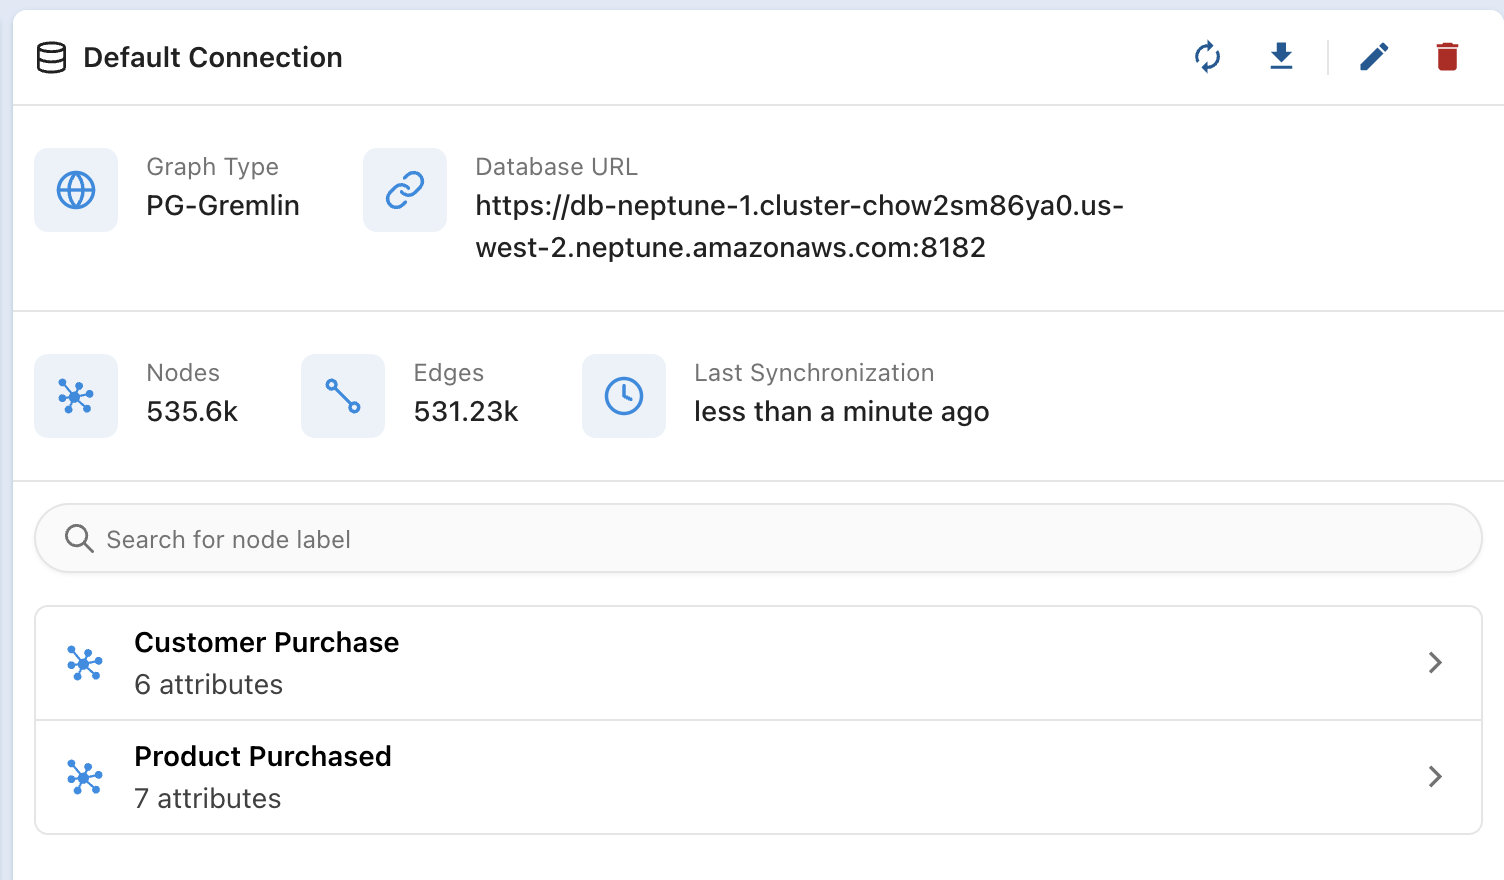

### Agent Set up using Strands SDK and Neptune MCP Server

We will now set up the LLM agent using Strands SDK by adding the tools from Neptune MCP server. By default strands use Claude 3.7 llm model and this can be changed if required as shown below.

```
import boto3
from strands import Agent
from strands.models import BedrockModel

# Create a BedrockModel
bedrock_model = BedrockModel(
    model_id="us.anthropic.claude-3-7-sonnet-20250219-v1:0",
    region_name='us-west-2',
    temperature=0.3,
)

agent = Agent(model=bedrock_model)
```


## Architecture

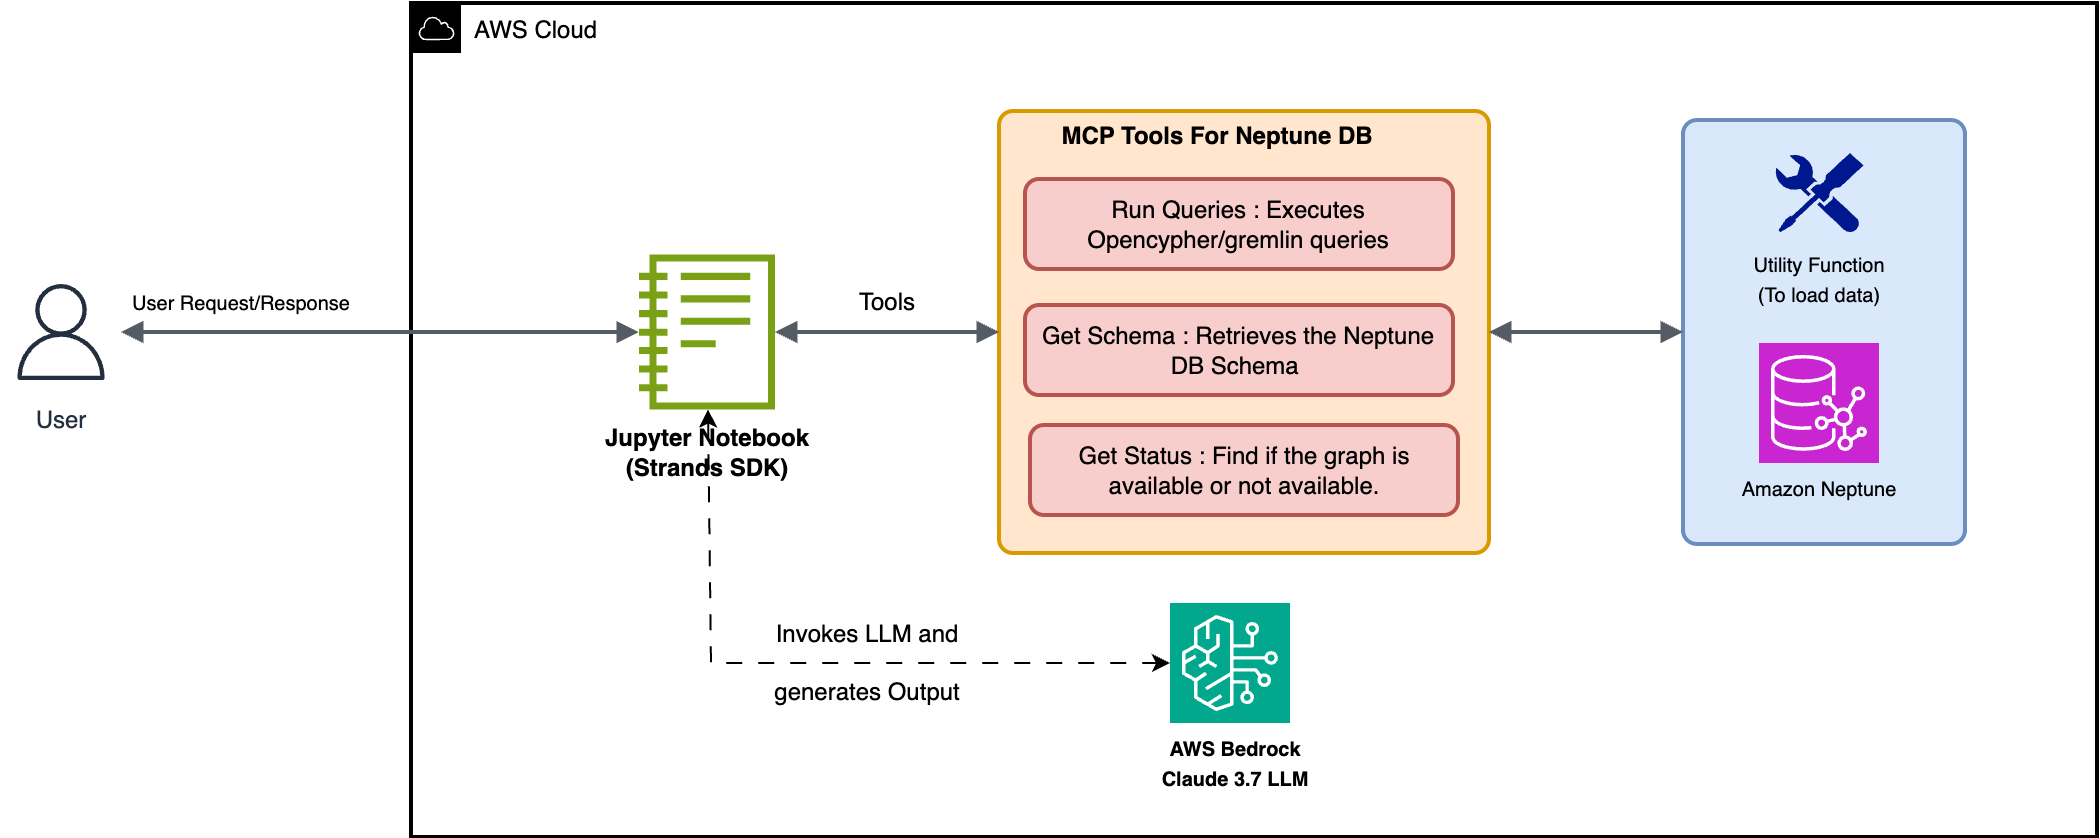


The implementation leverages the Strands Agents SDK in conjunction with the Model Composer Platform (MCP) tools to establish a seamless interaction framework between users, Amazon Bedrock LLM, and Neptune DB.

Within this architecture, the Strands Agents SDK serves as the primary intermediary, facilitating connections to the Neptune database through MCP tools. The system utilizes Amazon Bedrock LLM to formulate appropriate queries and execute them against the Neptune DB instance. Following successful data retrieval, the solution employs Bedrock LLM's processing capabilities to synthesize the information and deliver a comprehensive, user-friendly summary to the end user.

This integrated approach enhances data accessibility while maintaining robust processing workflows across all system components.

In [1]:
import threading
import time
from datetime import timedelta

from mcp import StdioServerParameters, stdio_client
from mcp.client.streamable_http import streamablehttp_client
from mcp.server import FastMCP
from strands import Agent
from strands.tools.mcp import MCPClient

In [2]:
# Connect to an Neptune MCP server using stdio transport
neptune_mcp_client = MCPClient(lambda: stdio_client(
        StdioServerParameters(
            command="uvx", args=["awslabs.amazon-neptune-mcp-server@latest"], env = {"NEPTUNE_ENDPOINT":"neptune-db://db-neptune-1.cluster-chow2sm86ya0.us-west-2.neptune.amazonaws.com"}
        )
    )
)

In [5]:
with neptune_mcp_client:
    # Get the tools from the MCP server
    tools = neptune_mcp_client.list_tools_sync() 

    # Create an agent with these tools
    agent = Agent(tools=tools, max_parallel_tools=1)

    response = agent(
        "Summarize the purchase details in america and get me what was purchased the most?"
    )

I'll help you analyze the purchase details in America and find out what was purchased the most. Let me first check the graph schema to understand what data we're working with.
Tool #8: get_graph_schema
Now I'll run a query to analyze purchases in America and find the most purchased product:
Tool #9: run_opencypher_query
Let me try a slightly different approach since I need to make sure I'm capturing data for America correctly:
Tool #10: run_opencypher_query
Great! Now I'll use "USA" as the country identifier to find the most purchased products:
Tool #11: run_opencypher_query
Let me also get some additional information about the total purchase volume and number of unique products:
Tool #12: run_opencypher_query
## Purchase Details in America - Summary

Based on the data analysis of purchases made in the USA, here's a summary of the purchase details:

### Most Purchased Products in America
1. **SET 12 COLOURING PENCILS DOILY** - 88 units purchased
2. **12 PENCILS SMALL TUBE RED RETROSPOT

### Result
#### Dataset in Neptune Graph DB contains around 500k entries of customer purchase details across different countries. Using Neptune MCP tools with Strands Agent SDK within few line of code we have got an excellent summary with detailed analysis of UK's Purchase details within few seconds. This also illustrates that by leveraging these relationship-centric data models in Neptune DB, AI agents can perform more sophisticated analytical operations, drawing deeper insights from multidimensional data connections and delivering more contextually relevant results to users. This relational intelligence significantly enhances the analytical precision and contexual awareness of the system.
